In [113]:
!mkdir -p "08-homework"
!wget "https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip" -O "08-homework/data.zip"
!pushd "08-homework/" && unzip -o data.zip && popd

--2026-02-16 16:54:56--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-16T17%3A48%3A29Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-16T16%3A48%3A18Z&ske=2026-02-16T17%3A48%3A29Z&sks=b&skv=2018-11-09&sig=Vszzn1wt1E1x%2Blp%2Fi9IV9jmnNw4qiB9b75ppDupmRiM%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MTI2MjY5NiwibmJmIjoxNzcxMjYwODk2LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi

In [114]:
# Prepare random seed

import numpy as np
import torch

device = 'cuda'
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    print("Using CUDA")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
else:
    print("Not using CUDA")

Using CUDA


In [115]:
torch.__version__

'2.10.0+cu128'

# Model


* The shape for input should be `(3, 200, 200)` (channels first format in PyTorch)
* Next, create a convolutional layer (`nn.Conv2d`):
    * Use 32 filters (output channels)
    * Kernel size should be `(3, 3)` (that's the size of the filter), padding = 0, stride = 1
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling (`nn.MaxPool2d`)
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using `flatten` or `view`
* Next, add a `nn.Linear` layer with 64 neurons and `'relu'` activation
* Finally, create the `nn.Linear` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `torch.optim.SGD` with the following parameters:

* `torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)`

Let's look at the data first...

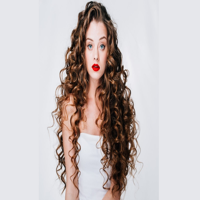

In [116]:
from PIL import Image

img = Image.open('08-homework/data/test/curly/Curls-1600x900.jpg')
img.resize((200, 200))

In [117]:
x = np.array(img.resize((200, 200)))
x.shape

(200, 200, 3)

## Prepare the dataset

In [118]:
import os
from torch.utils.data import Dataset

class HairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['curly', 'straight']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []

        # We populate from folders
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, filename)
                    self.samples.append((img_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [119]:
# Test
dataset = HairDataset(root_dir='08-homework/data/test', transform=None)
print(len(dataset))
dataset[0]

201


(<PIL.Image.Image image mode=RGB size=980x1466>, 0)

In [120]:
# Set up transforms
from torchvision import transforms

input_size = 200

train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])
val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [121]:
# Instantiate datasets and dataloaders
from torch.utils.data import DataLoader

batch_size = 32

train_dataset = HairDataset(
    root_dir='08-homework/data/train',
    transform=train_transforms
)

val_dataset = HairDataset(
    root_dir='08-homework/data/test',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

# Model Definition

In [122]:
import torch.nn as nn

class HairClassifier(nn.Module):
    def __init__(self):
        super(HairClassifier, self).__init__()

        # Convolutional layer (nn.Conv2d, 32 filters, kernel size (3, 3)):
        self.conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        # Activation layer (nn.ReLU):
        self.relu = nn.ReLU()
        # Reduce the size of the feature map with max pooling (nn.MaxPool2d) 
        self.pool = nn.MaxPool2d((2, 2))

        # Turn the multi-dimensional result into vectors using flatten or view
        self.flatten = nn.Flatten()

        # nn.Linear layer with 64 neurons and ReLU activation
        self.inner = nn.Linear(32*99*99, 64)
        self.relu_inner = nn.ReLU()

        # Final nn.Linear layer with 1 neuron
        self.output_layer = nn.Linear(64, 1)


    def forward(self, x):
        # Apply the convolutional layer and activation function
        x = self.conv_layer(x)
        x = self.relu(x)
        # Reduce the size of the feature map with max pooling
        x = self.pool(x)

        # Turn the multi-dimensional result into vectors using flatten or view
        x = self.flatten(x)
        # Apply the inner layer and activation function
        x = self.inner(x)
        x = self.relu_inner(x)

        # Apply the output layer
        x = self.output_layer(x)

        return x

## Question 1

In [123]:
def make_model(
        learning_rate=0.002,
):
    model = HairClassifier()
    model.to(device, non_blocking=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
    return model, optimizer

criterion = torch.nn.BCEWithLogitsLoss()

# Question 2

In [124]:
from torchsummary import summary
model = HairClassifier()
model.to(device, non_blocking=True)
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
           Flatten-4               [-1, 313632]               0
            Linear-5                   [-1, 64]      20,072,512
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 23.93
Params size (MB): 76.57
Estimated Total Size (MB): 100.96
----------------------------------------------------------------


# Question 3

In [125]:
batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True)

In [ ]:
model, optimizer = make_model()

def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs=10, device='cuda'):
    history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct_train / total_train
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                labels = labels.float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = correct_val / total_val
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}\n"
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
            f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    return history
        
history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs=10)

Epoch 1/10
Train Loss: 0.6434, Train Acc: 0.6417, Val Loss: 0.6151, Val Acc: 0.6468
Epoch 2/10
Train Loss: 0.5340, Train Acc: 0.7216, Val Loss: 0.6237, Val Acc: 0.6667
Epoch 3/10
Train Loss: 0.4877, Train Acc: 0.7466, Val Loss: 0.6464, Val Acc: 0.6517
Epoch 4/10
Train Loss: 0.4382, Train Acc: 0.7953, Val Loss: 0.6653, Val Acc: 0.6617
Epoch 5/10
Train Loss: 0.5399, Train Acc: 0.7228, Val Loss: 0.6658, Val Acc: 0.6667
Epoch 6/10
Train Loss: 0.4101, Train Acc: 0.8015, Val Loss: 0.6137, Val Acc: 0.6965
Epoch 7/10
Train Loss: 0.3177, Train Acc: 0.8589, Val Loss: 1.5387, Val Acc: 0.5025
Epoch 8/10
Train Loss: 0.4967, Train Acc: 0.8027, Val Loss: 0.5962, Val Acc: 0.6915
Epoch 9/10
Train Loss: 0.3017, Train Acc: 0.8602, Val Loss: 0.7230, Val Acc: 0.6766
Epoch 10/10
Train Loss: 0.2336, Train Acc: 0.9026, Val Loss: 0.5980, Val Acc: 0.7313


In [127]:
# median of training accuracies
np.median(history['acc'])

np.float64(0.7983770287141074)

## Question 4

In [128]:
# stdev of training losses
np.std(history['loss'])

np.float64(0.11969049824701049)

## Question 5

In [132]:
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

train_dataset = HairDataset(
    root_dir='08-homework/data/train',
    transform=train_transforms
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)

history = train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs=10)

Epoch 1/10
Train Loss: 0.3733, Train Acc: 0.8365, Val Loss: 0.7554, Val Acc: 0.7214
Epoch 2/10
Train Loss: 0.5482, Train Acc: 0.7566, Val Loss: 0.4862, Val Acc: 0.7711
Epoch 3/10
Train Loss: 0.4131, Train Acc: 0.8090, Val Loss: 0.4611, Val Acc: 0.7662
Epoch 4/10
Train Loss: 0.4131, Train Acc: 0.8140, Val Loss: 0.4623, Val Acc: 0.8109
Epoch 5/10
Train Loss: 0.4158, Train Acc: 0.8227, Val Loss: 0.4774, Val Acc: 0.7562
Epoch 6/10
Train Loss: 0.4001, Train Acc: 0.8215, Val Loss: 0.4668, Val Acc: 0.8010
Epoch 7/10
Train Loss: 0.4716, Train Acc: 0.7578, Val Loss: 0.5237, Val Acc: 0.7363
Epoch 8/10
Train Loss: 0.4231, Train Acc: 0.8240, Val Loss: 0.4776, Val Acc: 0.7861
Epoch 9/10
Train Loss: 0.4201, Train Acc: 0.8090, Val Loss: 0.6089, Val Acc: 0.7363
Epoch 10/10
Train Loss: 0.4114, Train Acc: 0.8115, Val Loss: 0.5391, Val Acc: 0.7811


In [133]:
# mean of test loss
np.mean(history['val_loss'])

np.float64(0.5258429142892063)

## Question 6

In [134]:
# average of test accuracy of last 5 epochs
np.average(history['val_acc'][-5:])

np.float64(0.7681592039800995)